In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from cmcrameri import cm 
from matplotlib.colors import LogNorm  
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
"""
I changed the code so that for each domain size it gives a dims_nxlen_nylen and an out_nxlen_ny_len file, with nxlen and nylen the size of the domain. The dims file give
the dimensions of nx and ny on rank number 0, to see how the domain is split up. Everything you run the code the thread and core number and runtime or dimensions will be
appended to those files and it will not get overwritten anymore. 
The speedup give the speedup compared to the base configuration of 1 core and 1 thread. 

I also added a part which allows to run on eiger supercomputer, I was curious if there would be differences, and it seems there is!
On eiger running on 2 mpi tasks is faster than on 4 mpi tasks. Maybe we can add a small part in the report about how it changes per supercomputer architecture.
"""

'\nI changed the code so that for each domain size it gives a dims_nxlen_nylen and an out_nxlen_ny_len file, with nxlen and nylen the size of the domain. The dims file give\nthe dimensions of nx and ny on rank number 0, to see how the domain is split up. Everything you run the code the thread and core number and runtime or dimensions will be\nappended to those files and it will not get overwritten anymore. \nThe speedup give the speedup compared to the base configuration of 1 core and 1 thread. \n'

In [2]:
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"
# os.environ["OMP_STACKSIZE"] = "1G"

In [ ]:
%%bash
if [[ $(hostname -s) == eiger-* ]]; then
uenv run prgenv-gnu/24.11:v2 --view=default -- make clean
uenv run prgenv-gnu/24.11:v2 --view=default -- make VERSION=kparallel_mpi
else
make clean
make VERSION=kparallel_mpi
fi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/*
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -fimplicit-none -c m_utils.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -fimplicit-none -c m_partitioner.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -fimplicit-none -c stencil2d-kparallel_mpi.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -fimplicit-none m_utils.o m_partitioner.o stencil2d-kparallel_mpi.o -o stencil2d-kparallel_mpi.x
cp stencil2d-kparallel_mpi.x stencil2d.x


In [ ]:
%%bash 
echo "$(hostname -s)"
if [[ $(hostname -s) == eiger-* ]]; then
    echo "You are on eiger"
fi

eiger-ln003
eiger-ln003
You are on eiger


In [9]:
%%bash

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims.txt

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out_eiger.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims_eiger.txt


for nthreads in $(seq 1 1); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 72 ]; then
    ncores=72
  fi

  # for nnodes in $(seq 1 6); do
  nnodes=1
    echo "Running with $nthreads threads and $nnodes MPI tasks"
    if [[ $(hostname -s) == eiger-* ]]; then
        output=$(uenv run prgenv-gnu/24.11:v2 --view=default -- srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    else    
        output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
    fi
    echo $output

    data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
    runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
    
    dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
    nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
    ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
       
    if [[ $(hostname -s) == eiger-* ]]; then
        echo "You are on eiger"
      printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out_eiger.txt
      printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims_eiger.txt
    else
        echo "You are on santis"
      printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out.txt
      printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims.txt
    fi
    echo "baseline runtime = $runtime"
    done
done
done
echo $'baseline runtime =$runtime'

Running with 1 threads and 1 MPI tasks


#threads = 1 # ranks nx ny nz num_iter time nx_rank0 ny_rank0 data = np.array( [ \ [ 128, 128] [ 128, 128] [ 1, 128, 128, 64, 1024, 0.6419993E+00], \ ] )
You are on eiger
baseline runtime = 0.6419993E+00


In [29]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

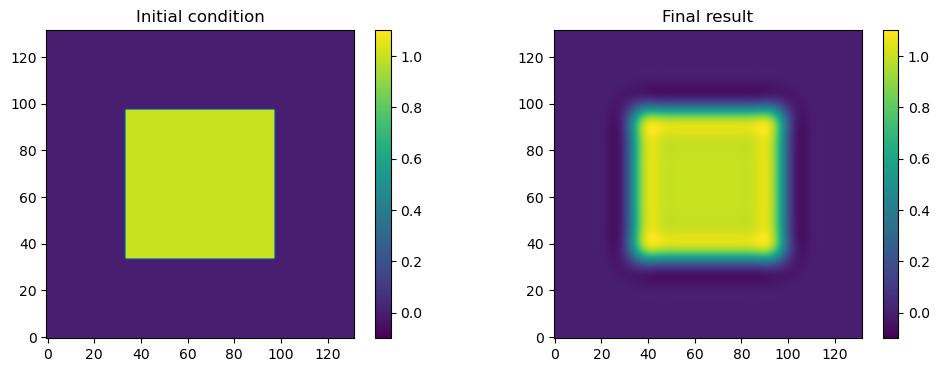

In [30]:
validate_results()

In [6]:
nx_len=128
ny_len=128

In [23]:
%%bash -s "$nx_len" "$ny_len"
nx_len=$1
ny_len=$2
echo "nx_len = $nx_len, ny_len = $ny_len"

out_file="out_${nx_len}_${ny_len}.txt"
dims_file="dims_${nx_len}_${ny_len}.txt"

if [[ $(hostname -s) == eiger-* ]]; then
  out_file="out_eiger_${nx_len}_${ny_len}.txt"
  dims_file="dims_eiger_${nx_len}_${ny_len}.txt"
fi

if [ ! -f "$out_file" ]; then
  echo "runtimes = [[0.0]*17 for _ in range(73)]" > "$out_file"
fi

if [ ! -f "$dims_file" ]; then
  echo "dimensions = [[0.0]*17 for _ in range(73)]" > "$dims_file"
fi

for nthreads in $(seq 5 72); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads

    for nnodes in $(seq 1 4); do
    # if (( nthreads * nnodes > 73 )); then
    #   nnodes=$(( 72 / nthreads ))
    # fi
      echo "Running with $nthreads threads and $nnodes MPI tasks"
    if [[ $(hostname -s) == eiger-* ]]; then
        output=$(uenv run prgenv-gnu/24.11:v2 --view=default -- srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    else    
        output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
    fi    
      data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
      runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
    
      dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
      nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
      ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
    
      # Update or append runtime
      if grep -q "runtimes\[$nthreads\]\[$nnodes\]" "$out_file"; then
        sed -i "s/runtimes\[$nthreads\]\[$nnodes\] = .*/runtimes[$nthreads][$nnodes] = $runtime/" "$out_file"
      else
        echo "runtimes[$nthreads][$nnodes] = $runtime" >> "$out_file"
      fi
    
      # Update or append dimensions
      if grep -q "dimensions\[$nthreads\]\[$nnodes\]" "$dims_file"; then
        sed -i "s/dimensions\[$nthreads\]\[$nnodes\] = .*/dimensions[$nthreads][$nnodes] = [$nx, $ny]/" "$dims_file"
      else
        echo "dimensions[$nthreads][$nnodes] = [$nx, $ny]" >> "$dims_file"
      fi
    done
done
done

nx_len = 128, ny_len = 128
Running with 5 threads and 1 MPI tasks
Running with 5 threads and 2 MPI tasks
Running with 5 threads and 3 MPI tasks
Running with 5 threads and 4 MPI tasks
Running with 6 threads and 1 MPI tasks
Running with 6 threads and 2 MPI tasks
Running with 6 threads and 3 MPI tasks
Running with 6 threads and 4 MPI tasks
Running with 7 threads and 1 MPI tasks


srun: interrupt (one more within 1 sec to abort)
srun: StepId=5462114.0 task 0: unknown


In [63]:
nx_len=128
ny_len=128

In [25]:
exec(open(f"out_eiger_{nx_len}_{ny_len}.txt", "r").read())
#### Define baseline runtime
T_baseline=runtimes[1][1]
print('baseline runtime', T_baseline)


labels = []
times = []
speedups= []
for nthreads in range(len(runtimes)):
    for nnodes in range(len(runtimes[nthreads])):
        runtime = runtimes[nthreads][nnodes]
        if runtime > 0.0:  # only plot entries that were filled
            labels.append([nthreads, nnodes])
            times.append(runtime)
            speedups.append(T_baseline/runtime)

baseline runtime 0.6462348


/tmp/ipykernel_188094/3002312050.py:12: RuntimeWarning: divide by zero encountered in divide
  runtimes_j = T_baseline/runtimes_array[:, j]


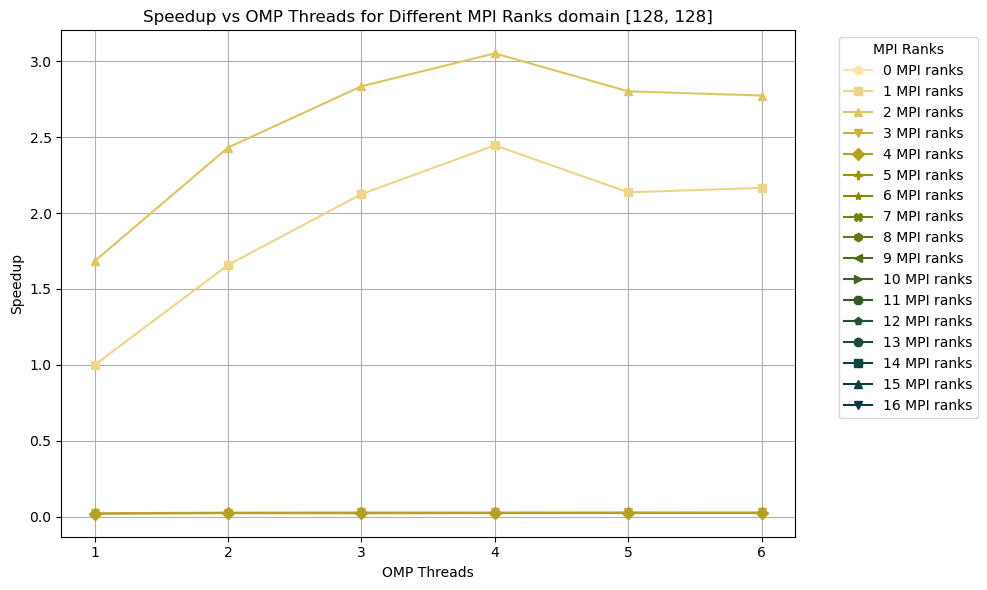

In [26]:
runtimes_array = np.array(runtimes)
nthreads = np.arange(len(runtimes_array))
nranks = np.arange(runtimes_array.shape[1])  # column indices = MPI ranks

plt.figure(figsize=(10, 6))

cmap = cm.bamako_r
colors = [cmap(i / (len(nranks) - 1)) for i in range(len(nranks))]
markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', 'h', '<', '>', '8', 'p']

for idx, (j, color) in enumerate(zip(nranks, colors)):
    runtimes_j = T_baseline/runtimes_array[:, j]
    if np.any(runtimes_j > 0):
        marker = markers[idx % len(markers)]  # Cycle through markers
        plt.plot(nthreads, runtimes_j, label=f"{j} MPI ranks", color=color, marker=marker)

plt.xlabel("OMP Threads")
plt.ylabel("Speedup")
plt.title(f"Speedup vs OMP Threads for Different MPI Ranks domain [{nx_len}, {ny_len}]")
plt.legend(title="MPI Ranks", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./plots/Speedup_domain_graphs_{nx_len}_{ny_len}', bbox_inches='tight', dpi=300)
plt.show()

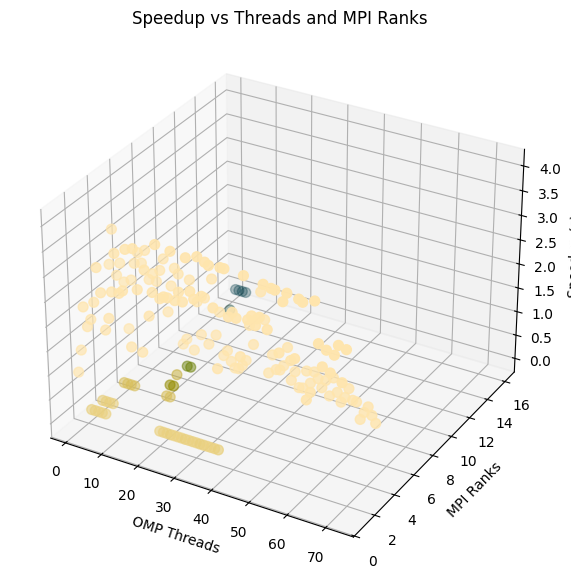

In [71]:

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

nthreads = [l[0] for l in labels]
ntasks = [l[1] for l in labels]

ax.scatter(nthreads, ntasks, speedups, c=times, cmap=cm.bamako_r, s=50)

ax.set_xlabel("OMP Threads")
ax.set_ylabel("MPI Ranks")
ax.set_zlabel("Speedup (s)")
ax.set_title("Speedup vs Threads and MPI Ranks")
plt.show()

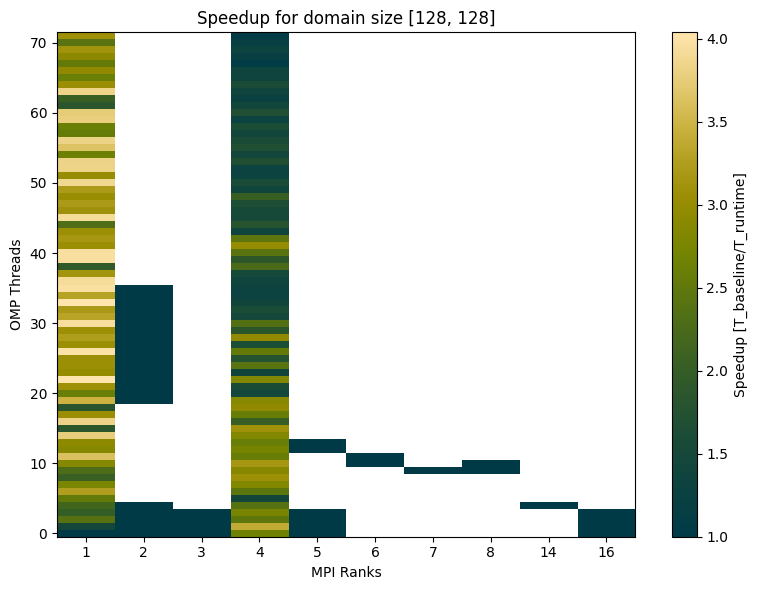

In [72]:
labels_array = np.array(labels)
nthreads = sorted(set(labels_array[:, 0]))
nranks = sorted(set(labels_array[:, 1]))

heatmap = np.full((len(nthreads), len(nranks)), np.nan)

for (t, r), val in zip(labels, speedups):
    i = nthreads.index(t)
    j = nranks.index(r)
    heatmap[i, j] = val

fig, ax = plt.subplots(figsize=(8, 6))
c = ax.imshow(heatmap, cmap=cm.bamako, origin='lower', 
              # extent=[min(nranks)-0.5, max(nranks)+0.5, min(nthreads)-0.5, max(nthreads)+0.5],
              # norm=LogNorm(vmin=np.nanmin(heatmap[heatmap > 0]), vmax=np.nanmax(heatmap)),
              vmin=1,
              aspect='auto')

ax.set_xlabel('MPI Ranks')
ax.set_ylabel('OMP Threads')
ax.set_title(f'Speedup for domain size [{nx_len}, {ny_len}]')
fig.colorbar(c, label='Speedup [T_baseline/T_runtime]')
ax.set_xticks(np.arange(len(nranks)))
ax.set_xticklabels(nranks)
plt.tight_layout()
plt.savefig(f'./plots/Speedup_domain_{nx_len}_{ny_len}', bbox_inches='tight', dpi=300)
plt.show()

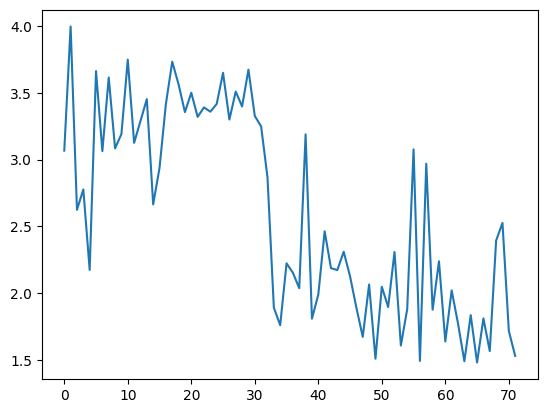

In [91]:
plt.plot(T_baseline/np.array(mpi_4[1:]))

In [8]:
# this is a utility function we will need below for parsing the performance analysis output
import re
import numpy as np
from pathlib import Path
from typing import Tuple

def parse_perf_stat(directory: Path = Path('./perf/')):
    mem_rd_values = []
    mem_wr_values = []
    llc_load_values = []

    for perf_file in sorted(directory.glob("?????.txt")):
        with perf_file.open() as f:
            lines = f.readlines()

            for line in lines:
                if 'mem_access_rd' in line:
                    mem_rd_values.append(int(line.strip().split()[0].replace(',', '')))
                elif 'mem_access_wr' in line:
                    mem_wr_values.append(int(line.strip().split()[0].replace(',', '')))
                elif 'LLC-load-misses' in line:
                    llc_load_values.append(int(line.strip().split()[0].replace(',', '')))

    total_llc_misses = float(np.array(llc_load_values).mean())
    total_mem_accesses = float(np.array(mem_rd_values).mean()) + float(np.array(mem_wr_values).mean())
    return (total_llc_misses * 64, total_mem_accesses * 4)

In [13]:
total_dram_accesses_per_core_in_Bytes, total_mem_accesses_per_core_in_Bytes = parse_perf_stat()
total_number_of_measured_GB = total_mem_accesses_per_core_in_Bytes * 72 / 1e9 # TODO
total_number_of_measured_DRAM_GB = total_dram_accesses_per_core_in_Bytes * 72 / 1e9 # TODO
total_number_of_counted_GB = 0.3537434E+12 / 1e9 # TODO

print("Total memory access measured = {} GB".format(total_number_of_measured_GB))
print("Total memory access measured (DRAM) = {} GB".format(total_number_of_measured_DRAM_GB))
print("Total memory access counted = {} GB".format(total_number_of_counted_GB))

Total memory access measured = 8150.914288224 GB
Total memory access measured (DRAM) = 133.877374848 GB
Total memory access counted = 353.7434 GB
